In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from detect_staircases import classify_staircase, identify_staircases_from_layers
plt.rcParams.update({'font.size': 14})

# Thermohaline classifier demo

This notebook demonstrates the functionality of the staircase classification algorithm

### Test classifier with synthetic data

First we create synthetic profiles of temperature and salinity data to check that the classifier works on idealised data. This is similar to the [internal software test](https://github.com/callumrollo/thermohaline-steps/blob/main/test_staircase.py) used in development

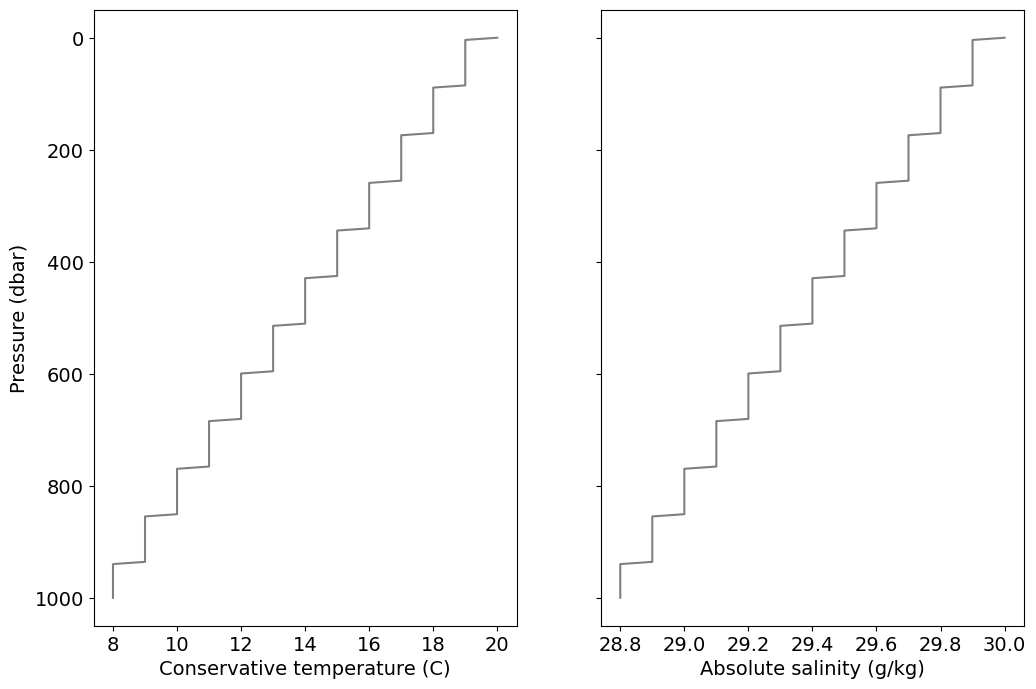

In [2]:
p_in = np.arange(1000)
ct_in = np.empty(len(p_in))
sa_in = np.empty(len(p_in))

diff_c = -1
diff_s = -0.1
mix = 80
interface = 5
current_c = 20
current_s = 30
for start in np.arange(0, 1000, mix+interface):
    ct_in[start: start + interface] = np.linspace(current_c, current_c + diff_c, interface)
    current_c +=diff_c
    ct_in[start + interface: start + interface + mix] = current_c
    sa_in[start: start + interface] = np.linspace(current_s, current_s + diff_s, interface)
    current_s +=diff_s
    sa_in[start + interface: start + interface + mix] = current_s  

fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
ax = ax.ravel()
ax[0].plot(ct_in, p_in, color="k", alpha=0.5)
ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
ax[1].plot(sa_in, p_in, color="k", alpha=0.5)
ax[1].set(xlabel="Absolute salinity (g/kg)")
ax[0].invert_yaxis()

df, mixes, grads = classify_staircase(p_in, ct_in, sa_in)

Next we run the classifier on this synthetic data and plot the results

In [3]:
df, mixes, grads = classify_staircase(p_in, ct_in, sa_in)

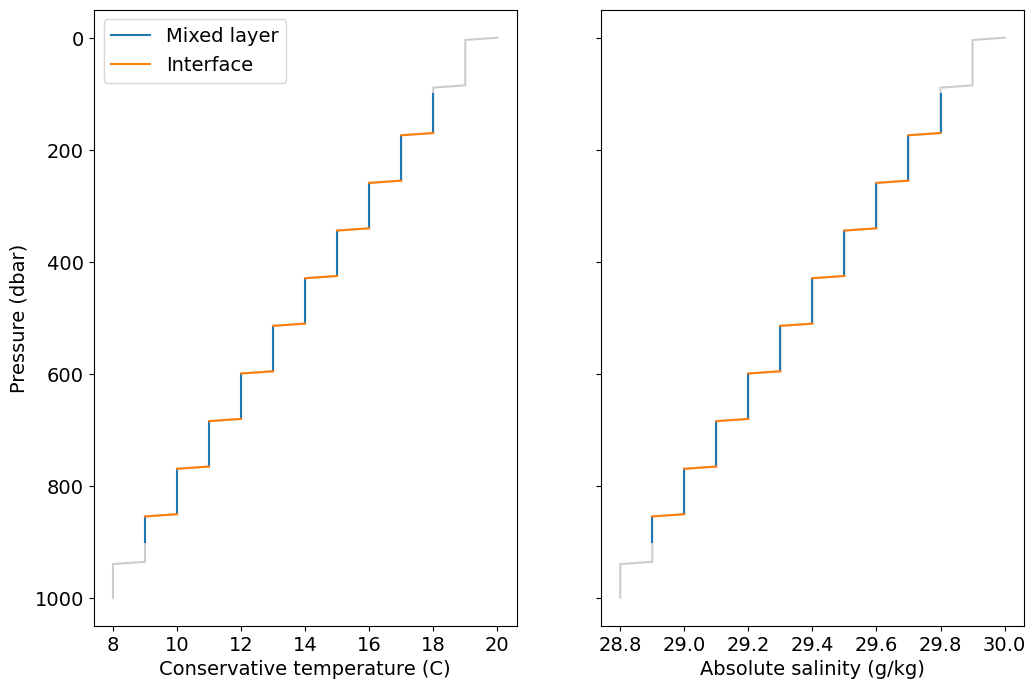

In [4]:
fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
ax = ax.ravel()
ax[0].plot(ct_in, p_in, color="k", alpha=0.2)
ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
ax[1].plot(sa_in, p_in, color="k", alpha=0.2)
ax[1].set(xlabel="Absolute salinity (g/kg)")

ax[0].plot(np.ma.array(df.ct, mask=df['mixed_layer_final_mask']), df.p, color='C0', label="Mixed layer")
ax[0].plot(np.ma.array(df.ct, mask=df['gradient_layer_final_mask']), df.p, color='C1', label="Interface")
ax[1].plot(np.ma.array(df.sa, mask=df['mixed_layer_final_mask']), df.p, color='C0')
ax[1].plot(np.ma.array(df.sa, mask=df['gradient_layer_final_mask']), df.p, color='C1')

ax[0].legend()
ax[0].invert_yaxis()

Due to the use of a rolling mean window to calculate background gradients, the upper and lower ends of the profile are not classified

### Experimentation

We can turn the above process into a function and re-run it with different input data

In [5]:
def classify_test_data(p, ct, sa, temp_flag_only=False):
    df, mixes, grads = classify_staircase(p, ct, sa, temp_flag_only=temp_flag_only)
    fig, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
    ax = ax.ravel()
    ax[0].plot(ct, p, color="k", alpha=0.2)
    ax[0].set(xlabel="Conservative temperature (C)", ylabel="Pressure (dbar)")
    ax[1].plot(sa, p, color="k", alpha=0.2)
    ax[1].set(xlabel="Absolute salinity (g/kg)")

    ax[0].plot(np.ma.array(df.ct, mask=df['mixed_layer_final_mask']), df.p, color='C0', label="Mixed layer")
    ax[0].plot(np.ma.array(df.ct, mask=df['gradient_layer_final_mask']), df.p, color='C1', label="Interface")
    ax[1].plot(np.ma.array(df.sa, mask=df['mixed_layer_final_mask']), df.p, color='C0')
    ax[1].plot(np.ma.array(df.sa, mask=df['gradient_layer_final_mask']), df.p, color='C1')

    ax[0].legend()
    ax[0].invert_yaxis()

Let's try adding some random noise to the input data salinity

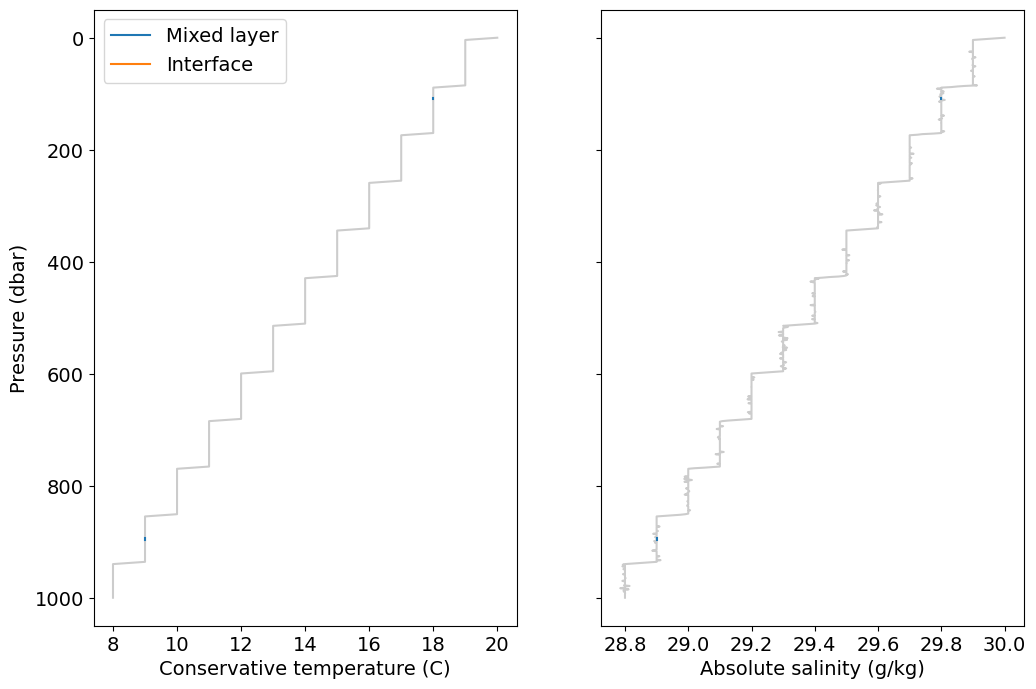

In [6]:
arr_len = len(p_in)
rand_sample_a = (np.random.random(arr_len) - 0.5) * np.random.randint(2, size=arr_len) * np.random.randint(2, size=arr_len)  * np.random.randint(2, size=arr_len) 
sa_noise = sa_in + 0.03 * rand_sample_a
classify_test_data(p_in, ct_in, sa_noise)

Using default setttins, noisy salinity prevents the identification of salinity data. For this reason, we use the `temp_flag_only` kwarg to perform the preliminary classification with temperature only

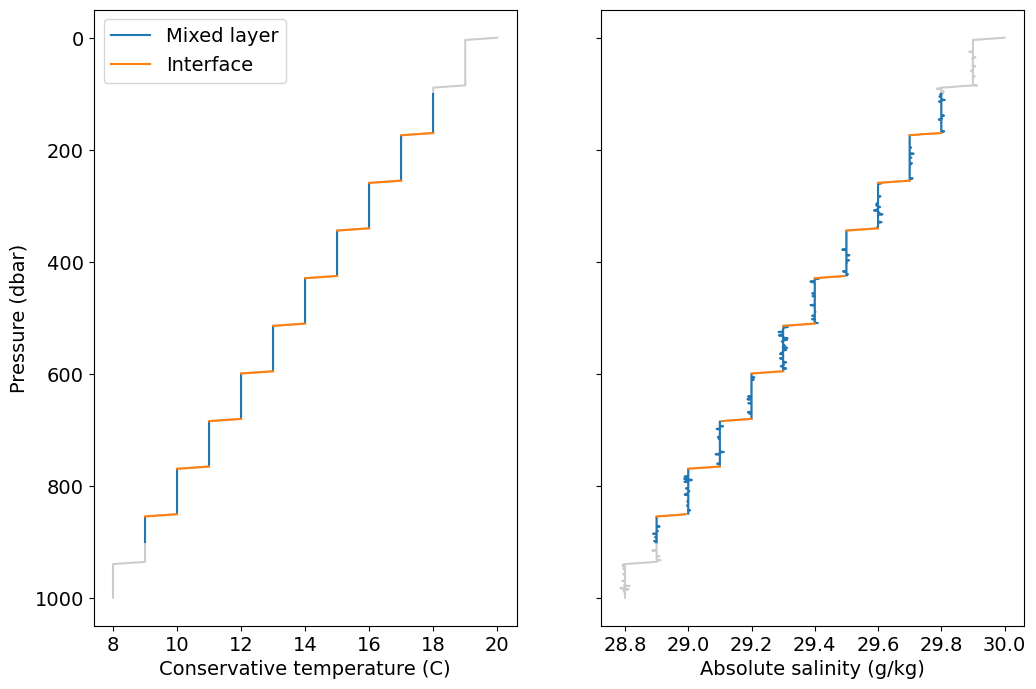

In [7]:
classify_test_data(p_in, ct_in, sa_noise, temp_flag_only=True)

As well as producing masks of final mixed layers and interfaces, the classifier returns the results of the classification steps and statistics on the mixed layers and interfaces

In [8]:
df.head()

,p,ct,sa,sigma1,alpha_smooth,beta_smooth,turner_ang,density_ratio,mixed_layer_final_mask,mixed_layer_temp_mask,...,mixed_layer_mask,gradient_layer_final_mask,mixed_layer_step1_mask,grad_layer_step2_mask,grad_layer_step3_mask,grad_layer_step4_mask,mixed_layer_salt_finger_mask,gradient_layer_salt_finger_mask,mixed_layer_diffusive_convective_mask,gradient_layer_diffusive_convective_mask
1,1,19.75,29.975,25.244920,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
2,2,19.50,29.950,25.292681,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
3,3,19.25,29.925,25.339905,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
4,4,19.00,29.900,25.386590,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True
5,5,19.00,29.900,25.386590,NaN,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,True,True,True,True


In [9]:
mixes

,p_start,p_end,ct,sa,sigma1,p,ct_range,sa_range,sigma1_range,layer_height,turner_ang,density_ratio,salt_finger_step,diffusive_convection_step,diffusive_convection,bad_mixed_layer
0,100.0,169.0,18.0,29.8,25.567890,134.5,0.0,0.0,0.0,69.0,43.278137,2.447287,True,False,True,False
1,175.0,254.0,17.0,29.7,25.740367,214.5,0.0,0.0,0.0,79.0,38.721540,3.038346,True,False,NaN,False
2,260.0,339.0,16.0,29.6,25.903856,299.5,0.0,0.0,0.0,79.0,39.109213,2.929007,True,False,NaN,False
3,345.0,424.0,15.0,29.5,26.058186,384.5,0.0,0.0,0.0,79.0,41.776621,2.606176,True,False,NaN,False
4,430.0,509.0,14.0,29.4,26.203182,469.5,0.0,0.0,0.0,79.0,39.977256,2.708077,True,False,NaN,False
5,515.0,594.0,13.0,29.3,26.338656,554.5,0.0,0.0,0.0,79.0,41.590183,2.494612,True,False,NaN,False
6,600.0,679.0,12.0,29.2,26.464417,639.5,0.0,0.0,0.0,79.0,59.557648,1.521423,True,False,NaN,False
7,685.0,764.0,11.0,29.1,26.580262,724.5,0.0,0.0,0.0,79.0,41.572729,2.370605,True,False,NaN,False
8,770.0,849.0,10.0,29.0,26.685977,809.5,0.0,0.0,0.0,79.0,44.454507,2.086042,True,False,NaN,False
9,855.0,900.0,9.0,28.9,26.781339,877.5,0.0,0.0,0.0,45.0,39.907037,2.001343,True,False,True,False


In [10]:
grads

,p_start,p_end,ct,sa,sigma1,p,ct_range,sa_range,sigma1_range,layer_height,turner_ang,density_ratio,bad_grad_layer,adj_ml_height,height_ratio,salt_finger,diffusive_convection,salt_finger_step,diffusive_convection_step
0,170.0,174.0,17.5,29.75,25.654685,172.0,1.0,0.1,0.172477,4.0,62.916891,3.092945,False,79.0,19.75,True,False,True,False
1,255.0,259.0,16.5,29.65,25.822678,257.0,1.0,0.1,0.163489,4.0,63.527239,2.983973,False,79.0,19.75,True,False,True,False
2,340.0,344.0,15.5,29.55,25.981599,342.0,1.0,0.1,0.154331,4.0,64.183553,2.874269,False,79.0,19.75,True,False,True,False
3,425.0,429.0,14.5,29.45,26.131273,427.0,1.0,0.1,0.144995,4.0,64.891124,2.763811,False,79.0,19.75,True,False,True,False
4,510.0,514.0,13.5,29.35,26.271520,512.0,1.0,0.1,0.135475,4.0,65.656094,2.652573,False,79.0,19.75,True,False,True,False
5,595.0,599.0,12.5,29.25,26.402150,597.0,1.0,0.1,0.125761,4.0,66.485622,2.540521,False,79.0,19.75,True,False,True,False
6,680.0,684.0,11.5,29.15,26.522966,682.0,1.0,0.1,0.115844,4.0,67.388095,2.427618,False,79.0,19.75,True,False,True,False
7,765.0,769.0,10.5,29.05,26.633759,767.0,1.0,0.1,0.105715,4.0,68.373384,2.313817,False,79.0,19.75,True,False,True,False
8,850.0,854.0,9.5,28.95,26.734313,852.0,1.0,0.1,0.095362,4.0,69.453168,2.199066,False,79.0,19.75,True,False,True,False


# Classifier on Argo data

Here we use Argo data from the Meditteranean to test the classifier against a real world example.

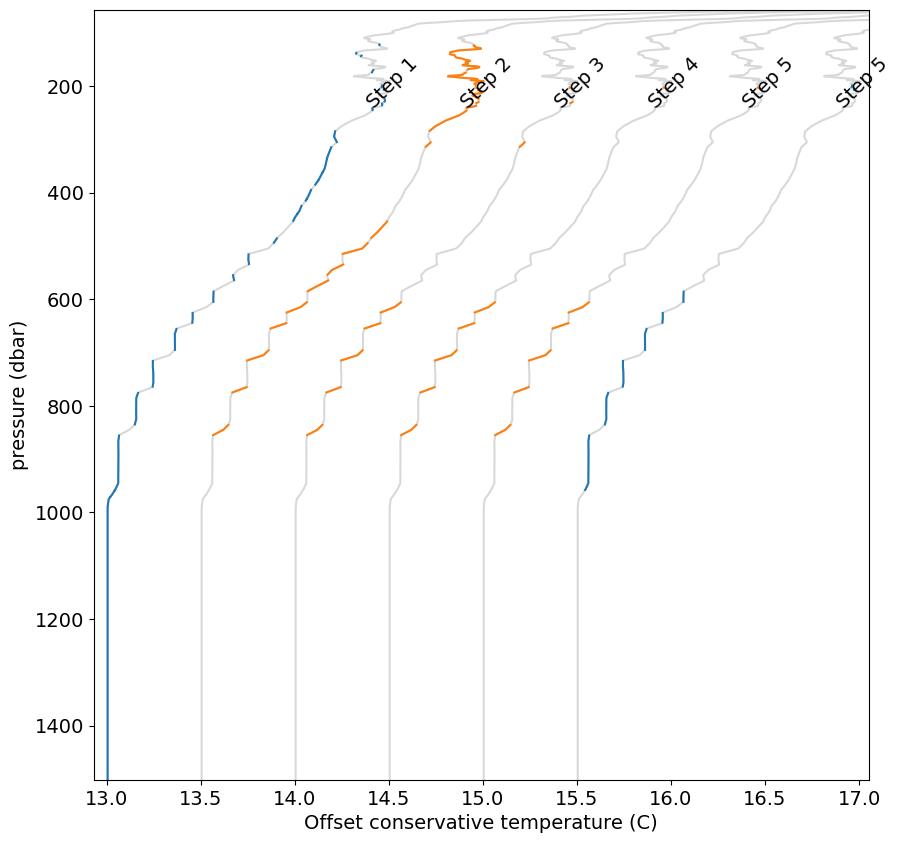

In [11]:
df_in = pd.read_csv('data/vanderboog_argo_demo_data.csv')
df_out, mixes, grads = classify_staircase(df_in.pressure, df_in.conservative_temperature, df_in.absolute_salinity,
                                          temp_flag_only=True, show_steps=True)

Making two small changes to the kwargs, we obtain a better classification of this staircase 

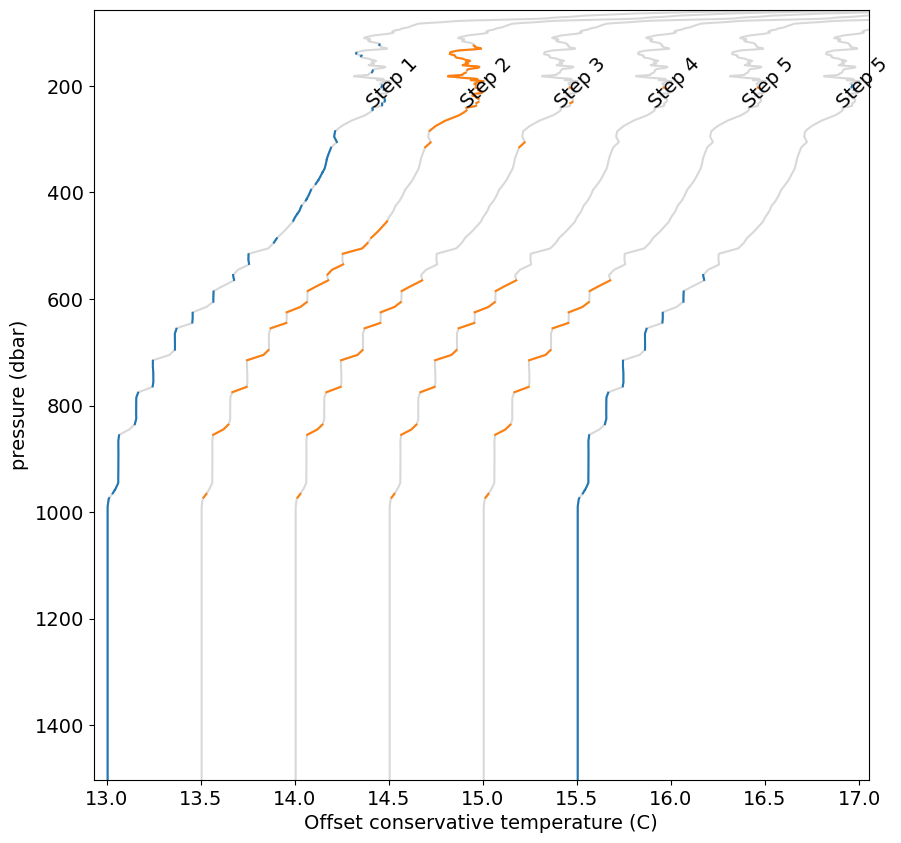

In [12]:
df_out, mixes, grads = classify_staircase(df_in.pressure, df_in.conservative_temperature, df_in.absolute_salinity,
                                          temp_flag_only=True, show_steps=True, layer_height_ratio=0.95, ml_grad=0.00048)

# Split into individual staircases

the function `identify_staircases_from_layers` takes the output from `classify_staircase` and groups the adjacent mixed layers and gradient layers together into individual staircases. The user can set the maximum distance between adjacent layers for them to cound in the same staricases. This can be useful with noisy data that may make small apparent breaks in staircases

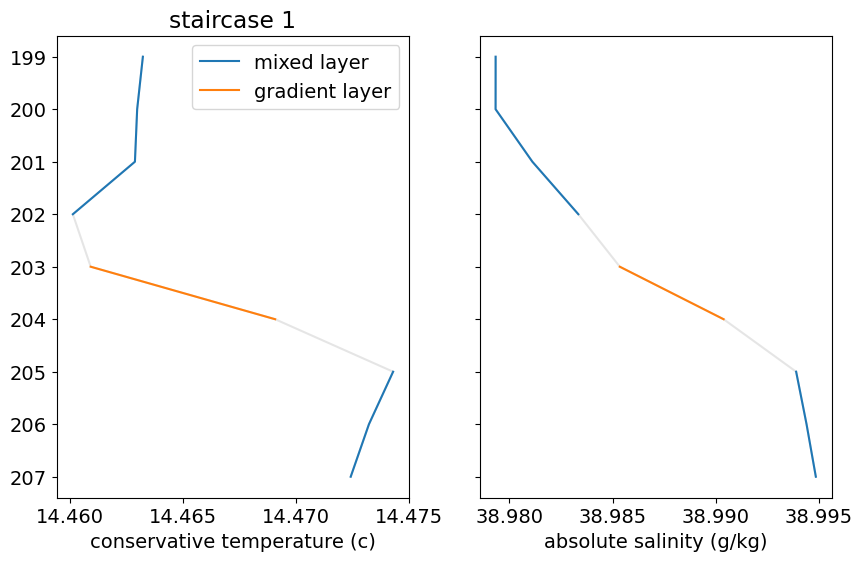

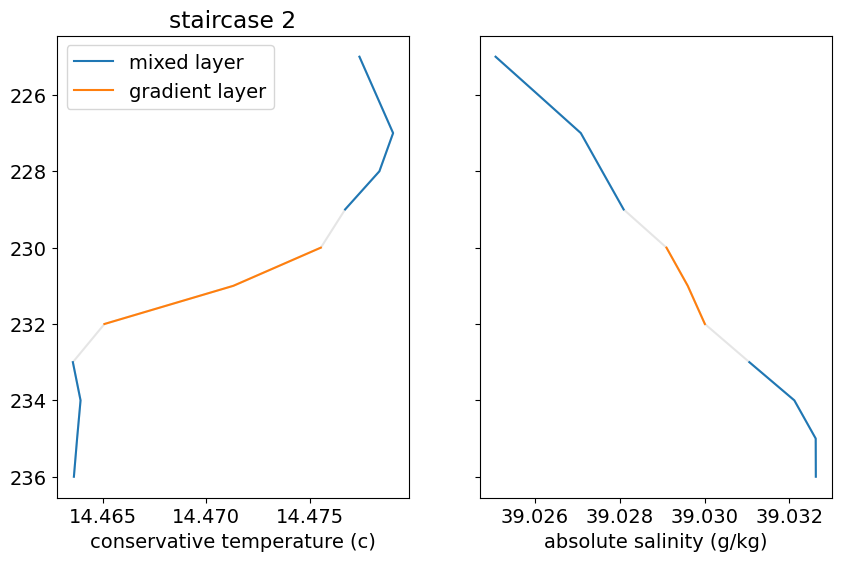

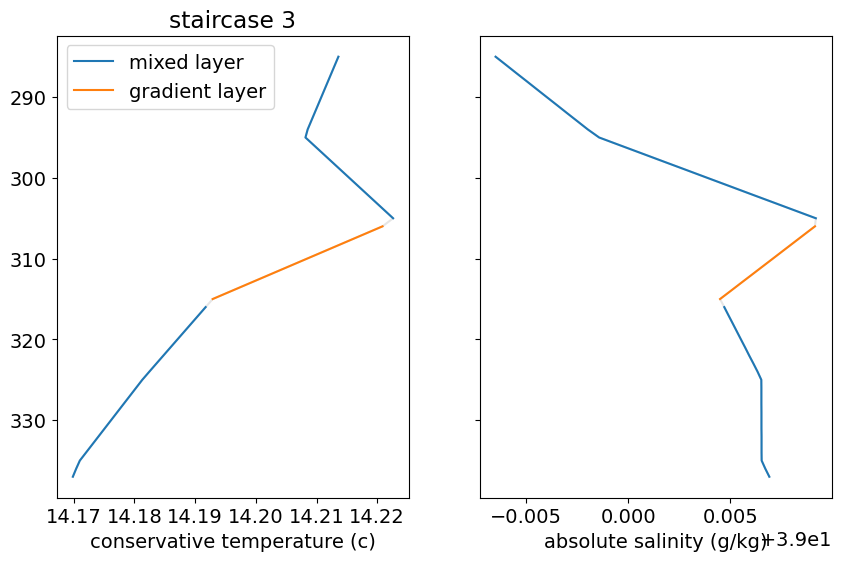

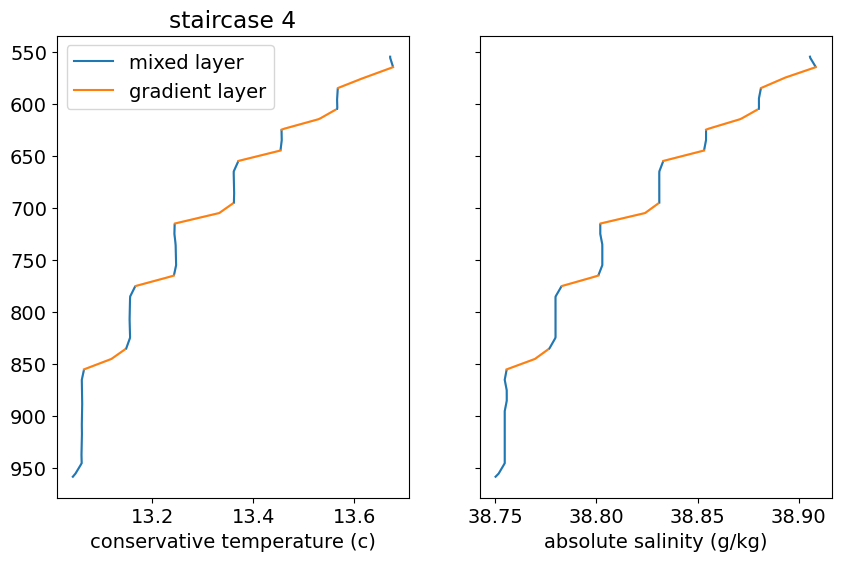

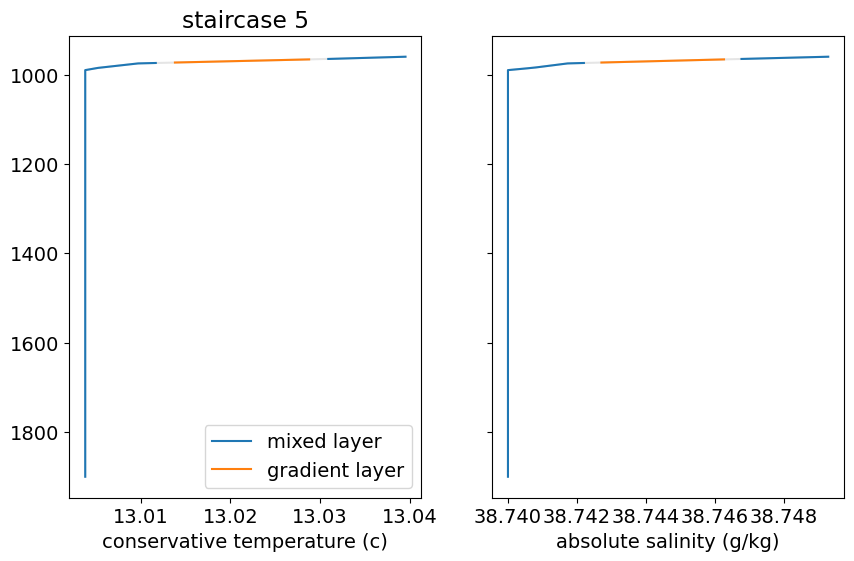

In [13]:
staircases_stats, staircases_full_dataframes = identify_staircases_from_layers(df_out, mixes, grads, show_plot=True)

Here's the summary stats from the largest staircase in this profile

In [14]:
staircases_stats[3]

,p_start,p_end,ct,sa,sigma1,p,ct_range,sa_range,sigma1_range,layer_height,...,salt_finger_step,diffusive_convection_step,diffusive_convection,bad_mixed_layer,mixed_layer,gradient_layer,bad_grad_layer,adj_ml_height,height_ratio,salt_finger
9,555.0,564.0,13.673370,38.906707,33.472846,559.5,0.005200,0.002577,0.000733,9.0,...,True,False,NaN,False,True,False,NaN,NaN,NaN,NaN
10,565.0,585.0,13.621361,38.894149,33.475522,575.0,0.108940,0.026981,0.005076,20.0,...,True,False,False,NaN,False,True,False,19.0,0.950000,True
11,586.0,605.0,13.566393,38.880519,33.478061,595.5,0.001340,0.000975,0.000463,19.0,...,True,False,NaN,False,True,False,NaN,NaN,NaN,NaN
12,606.0,625.0,13.517085,38.868375,33.480366,615.5,0.106411,0.025117,0.005779,19.0,...,True,False,False,NaN,False,True,False,19.0,1.000000,True
13,626.0,644.0,13.455763,38.853954,33.483729,635.0,0.002221,0.000901,0.000251,18.0,...,True,False,NaN,False,True,False,NaN,NaN,NaN,NaN
14,645.0,655.0,13.412335,38.843148,33.485630,650.0,0.083274,0.020092,0.004113,10.0,...,True,False,False,NaN,False,True,False,39.0,3.900000,True
15,656.0,695.0,13.362804,38.831331,33.488169,675.5,0.008453,0.001808,0.000589,39.0,...,True,False,NaN,False,True,False,NaN,NaN,NaN,NaN
16,696.0,715.0,13.315261,38.819657,33.490323,705.5,0.113709,0.028274,0.004857,19.0,...,True,False,False,NaN,False,True,False,48.0,2.526316,True
17,716.0,764.0,13.245710,38.802499,33.493389,740.0,0.003939,0.001789,0.000664,48.0,...,True,False,NaN,False,True,False,NaN,NaN,NaN,NaN
18,765.0,775.0,13.205464,38.792097,33.494775,770.0,0.075610,0.017925,0.003822,10.0,...,True,False,False,NaN,False,True,False,59.0,5.900000,True


And here is the corresponding table of original data across this span of the profile

In [15]:
staircases_full_dataframes[3]

,p,ct,sa,sigma1,alpha_smooth,beta_smooth,turner_ang,density_ratio,mixed_layer_final_mask,mixed_layer_temp_mask,...,mixed_layer_mask,gradient_layer_final_mask,mixed_layer_step1_mask,grad_layer_step2_mask,grad_layer_step3_mask,grad_layer_step4_mask,mixed_layer_salt_finger_mask,gradient_layer_salt_finger_mask,mixed_layer_diffusive_convective_mask,gradient_layer_diffusive_convective_mask
555,555.0,13.671032,38.905500,33.472480,0.000220,0.000738,84.317549,1.220998,False,False,...,False,True,False,True,True,True,False,True,True,True
556,556.0,13.671029,38.905605,33.472560,0.000220,0.000738,84.328121,1.220539,False,False,...,False,True,False,True,True,True,False,True,True,True
557,557.0,13.671679,38.905914,33.472642,0.000220,0.000738,84.338480,1.220089,False,False,...,False,True,False,True,True,True,False,True,True,True
558,558.0,13.672329,38.906223,33.472724,0.000220,0.000738,84.347829,1.219683,False,False,...,False,True,False,True,True,True,False,True,True,True
559,559.0,13.672979,38.906532,33.472805,0.000220,0.000738,84.357800,1.219250,False,False,...,False,True,False,True,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954.0,13.049383,38.752106,33.500278,0.000221,0.000735,85.606399,1.166456,False,False,...,False,True,False,True,True,True,False,True,True,True
955,955.0,13.048141,38.751804,33.500333,0.000221,0.000735,85.606274,1.166461,False,False,...,False,True,False,True,True,True,False,True,True,True
956,956.0,13.046418,38.751300,33.500344,0.000221,0.000735,85.605875,1.166478,False,False,...,False,True,False,True,True,True,False,True,True,True
957,957.0,13.044697,38.750797,33.500357,0.000221,0.000735,85.605207,1.166505,False,False,...,False,True,False,True,True,True,False,True,True,True


### Help on the classifier

By calling `help()` on the classifier, we can view the docstring and see definitions of the variables that must be passed to it, and what the classifier kwargs are

In [16]:
help(classify_staircase)

Help on function classify_staircase in module detect_staircases:

classify_staircase(p, ct, sa, ml_grad=0.0005, ml_density_difference=0.005, av_window=200, interface_max_height=30, layer_height_ratio=1, temp_flag_only=False, show_steps=False)
    all data should be at 1 dbar resolution (for now)
    Notes:
    - Currently dropping min and max pressure values, so can have Turner angle at all points
    - Turner angle and stability-ratio from smoothed profile
    :param show_steps: if True, creates and shows a plot of filtering steps, default: False
    :param p: pressure (dbar)
    :param ct: conservative temperature (degrees celsius)
    :param sa: absolute salinity (g kg-1)
    :param ml_grad: density gradient for detection of mixed layer (kg m^-3 dbar^-1), default: 0.0005
    :param ml_density_difference: maximum density gradient difference of mixed layer (kg m^-3), default: 0.005
    :param av_window: averaging window to obtain background profiles (dbar), default: 200
    :param int